# Prédiction des émissions de CO2

### Variable 'TotalGHGEmissions' : variable d’émission du bâtiment

**Definition** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. 

This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available.

Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.

In [1]:
#on importe les bibliothèques dont on va se servir
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import RidgeCV , Ridge
from sklearn import kernel_ridge
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import ElasticNetCV 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

In [2]:
#Fonctions dont on va se servir

'''Fonction qui retourne un tableau contenant le nom de la variable, le nombre de valeur manquante ainsi que le 
pourcentage de valeurs manquantes associé '''

def missingValues(df):
    df_null = pd.DataFrame({'Count' : df.isnull().sum(), 'Percentage': round(100*df.isnull().sum()/len(df),2)})
    df_null_pos = df_null[df_null['Count'] > 0 ]
    df_null_sorted = df_null_pos.sort_values(by=['Percentage'], ascending = False)
    df_null_sorted = pd.DataFrame(df_null_sorted)
    df_null_sorted.reset_index(inplace = True)
    df_null_sorted.rename(columns={'index':'Variable Name'}, inplace=True)
    return df_null_sorted

'''Cette fonction permet de supprimer les variables avec un pourcentage de valeur manquante supérieur à la limite'''
def dropColumns(df, limit):
    tab = missingValues(df)
    columns_to_keep = list()

    for row in tab.iterrows():        
        if float(row[1]['Percentage']) < float(limit):
            columns_to_keep.append(row[1]['Variable Name'])
            
    data = df[columns_to_keep]
    return data

def add_results(regressor, nom_modèle, cas, results):
    results = results.append(pd.DataFrame({'Modèle' : [nom_modèle],
                                       'Cas': cas,
                                       'Score_RMSE_test' : [np.sqrt(mean_squared_error(regressor.predict(X_test_std), y_test))],
                                       'Score_RMSE_train' : [np.sqrt(mean_squared_error(regressor.predict(X_train_std), y_train))],
                                     'Score_r2_test': [regressor.score(X_test_std,y_test)],
                                      'Score_r2_train': [regressor.score(X_train_std,y_train)]
                                      }),ignore_index=True)
    return results 

In [3]:
df = pd.read_csv('df.csv', index_col = 0)
df.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,PropertyUse_ratio_Education,PropertyUse_ratio_Factory,PropertyUse_ratio_Government services,PropertyUse_ratio_Health,PropertyUse_ratio_Hotel/Senior Care/Housing,PropertyUse_ratio_Leisure,PropertyUse_ratio_No Use,PropertyUse_ratio_Office,PropertyUse_ratio_Other,PropertyUse_ratio_Parking,PropertyUse_ratio_Retail,PropertyUse_ratio_Swimming Pool,PropertyUse_ratio_Technology/Science,Electricity_ratio,Steam_ratio,NaturalGas_ratio,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,NumberofBuildings_log,NumberofFloors_log,PropertyGFATotal_log,PropertyGFAParking_log,PropertyGFABuilding(s)_log,SiteEnergyUseWN(kBtu)_log,TotalGHGEmissions_log
0,47.61220,-122.33799,1927,1.0,12,88434,0,88434,60.0,7456910.0,249.98,0.0,0.0,0.0,0.0,100.000000,0.000000,0,0.0,0.0,0.000000,0.0,0,0.0,0.546060,0.277302,0.176638,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.564949,11.390023,0.000000,11.390023,15.824652,5.525373
1,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,61.0,8664479.0,295.86,0.0,0.0,0.0,0.0,80.991831,4.462855,0,0.0,0.0,14.545314,0.0,0,0.0,0.386609,0.000000,0.613391,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.484907,11.547974,9.620129,11.390792,15.974742,5.693261
2,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,43.0,73937112.0,2089.28,0.0,0.0,0.0,0.0,100.000000,0.000000,0,0.0,0.0,0.000000,0.0,0,0.0,0.682307,0.297113,0.020579,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,3.737670,13.770629,12.189532,13.540275,18.118725,7.645053
3,47.61412,-122.33664,1926,1.0,10,61320,0,61320,56.0,6946800.5,286.43,0.0,0.0,0.0,0.0,100.000000,0.000000,0,0.0,0.0,0.000000,0.0,0,0.0,0.407519,0.325913,0.266567,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.397895,11.023878,0.000000,11.023878,15.753792,5.660979
4,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,75.0,14656503.0,505.01,0.0,0.0,0.0,0.0,64.477629,0.000000,0,0.0,0.0,35.522371,0.0,0,0.0,0.378802,0.000000,0.621198,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.944439,12.075856,11.034906,11.640272,16.500395,6.226556


#### On sépare les différents types de colonnes

In [4]:
df_columns = pd.DataFrame({'feature': df.columns})

columns_PrimaryPropertyType = df_columns.loc[df_columns['feature'].str.startswith('PrimaryPropertyType_')]['feature'].tolist()
columns_Neighborhood = df_columns.loc[df_columns['feature'].str.startswith('Neighborhood_')]['feature'].tolist()
columns_PropertyUse_ratio = df_columns.loc[df_columns['feature'].str.startswith('PropertyUse_ratio_')]['feature'].tolist()
columns_BuildingType = df_columns.loc[df_columns['feature'].str.startswith('BuildingType_')]['feature'].tolist()


## Premiere iteration avec peu de variables

On va selectionner les variables pour l'étude :

- primaryPropertyType :usage principal du batiment
- BuildingType : type de batiment
- YearBuilt : date de construction du batiment
- Neighborhood : feature geographique qui apporte de la valeur
- PropertyGFATotal : Total building and parking gross floor area : surface totale du bâtiment
- PropertyGFAParking : proportion de surface de parking (les parkings consomment moins que le reste du batiment)
- NumberofFloors : nombre d'étages
- NumberofBuildings : nombre de batiments


- les taux de consommation d’électricité, de gaz et de vapeur seront calculés ???

In [5]:
#on supprime l'autre variable de prediction qu'on va predire dans l'autre notebook
# et les variables qui nous semble pas pertinentes
#ainsi que la variable ou il y a des Nan

df_1er_essai = df.drop(['SiteEnergyUseWN(kBtu)',
                        'ENERGYSTARScore',
                        'Electricity_ratio',
                        'Steam_ratio',
                        'NaturalGas_ratio',
                        'NumberofBuildings_log',
                        'NumberofFloors_log', 
                        'PropertyGFATotal_log',
                        'PropertyGFAParking_log',
                        'PropertyGFABuilding(s)_log',
                        'SiteEnergyUseWN(kBtu)_log',
                        'TotalGHGEmissions_log'] + columns_PropertyUse_ratio , axis=1)

<AxesSubplot:>

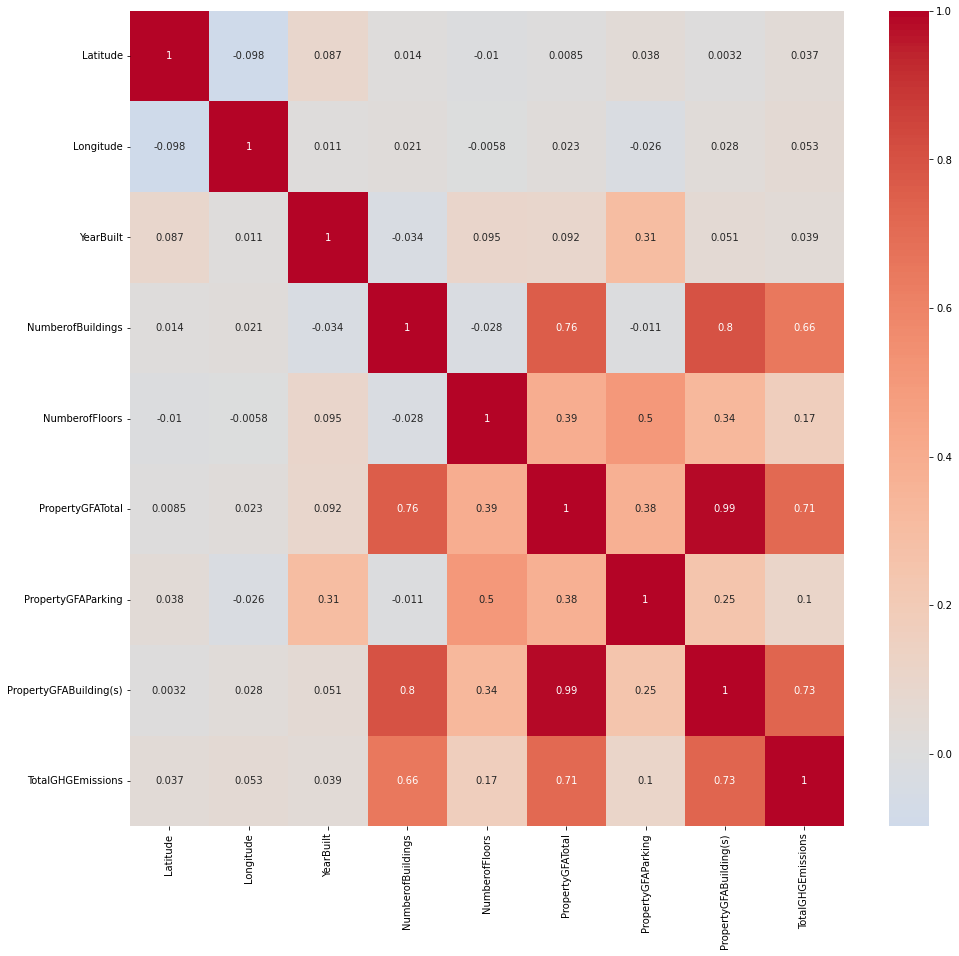

In [6]:
#on affiche une heatmap de correlation entre chaque variables 
plt.figure(figsize=(16, 15))
sns.heatmap(df_1er_essai[df_1er_essai.columns[:9]].corr(), annot=True, cmap='coolwarm', center = 0)

### On sépare la variable cible et les features 

Nous allons séparer les données en un ensemble de données X et une variable cible y que nous voulons prédire.

Nous allons utiliser différents algorithmes de régression pour prédire y et comparer leurs scores pour pouvoir choisir le meilleur.

In [7]:
X= df_1er_essai.drop(['TotalGHGEmissions'], axis=1)
y = df_1er_essai['TotalGHGEmissions']

#### On crée un dataframe où on enregistrera les scores de chaque algorithme utilisé 

In [8]:
results = pd.DataFrame({})

#### On separe les données d'entrainement et de test

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#### On standardise les données numérique 

In [10]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train_std = pd.DataFrame(data=standardScaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=standardScaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Dummy Regressor
Algorithme de reference pour avoir un score de reference

In [11]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_std, y_train)

DummyRegressor()

In [12]:
# Score R2
print('score train :', dummy.score(X_train_std, y_train))
print('score test :', dummy.score(X_test_std, y_test))
# R2 Score de 0 donc l'amelioration de notre modelisation se fait dans la fourchette de 0 à 1


#Score RMSE
print('rmse train :', np.sqrt(mean_squared_error(dummy.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(dummy.predict(X_test_std), y_test)))


score train : 0.0
score test : -0.004598133570565599
rmse train : 537.497975399512
rmse test : 296.5460615244711


In [13]:
# On ajoute les scores au dataframe results
results = add_results(dummy,'Dummy Regressor', 'Premières prédictions', results)

## Regression regularisées : Regression Ridge et Lasso

### Regression Ridge

La régression ridge nous permet de réduire l'amplitude des coefficients d'une régression linéaire et d'éviter le sur-apprentissage.

In [14]:
#l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard 
# on cherche le coefficient de regularisation alpha adapté
#on va tester un certain nombre de coefficients pour trouver celui qui est optimal

aphas =(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 20, 30, 50, 100, 200, 300, 350, 400)
ridge_reg = RidgeCV(alphas = aphas, scoring = 'r2')
ridge_reg.fit(X_train_std, y_train)


RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 3.0e-01, 7.0e-01, 1.0e+00, 1.0e+01,
       2.0e+01, 3.0e+01, 5.0e+01, 1.0e+02, 2.0e+02, 3.0e+02, 3.5e+02,
       4.0e+02]),
        scoring='r2')

In [15]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

# Score R2
print('score train :', ridge_reg.score(X_train_std, y_train))
print('score test :', ridge_reg.score(X_test_std, y_test))

#Score RMSE
print('rmse train :', np.sqrt(mean_squared_error(ridge_reg.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(ridge_reg.predict(X_test_std), y_test)))

alpha sélectionné par c-v : 50.0
score train : 0.7836461388540163
score test : 0.485615873709177
rmse train : 250.01102338737158
rmse test : 212.19725228192814


In [16]:
# On ajoute les scores au dataframe results
results = add_results(ridge_reg, 'RidgeCV', 'Premières prédictions', results)

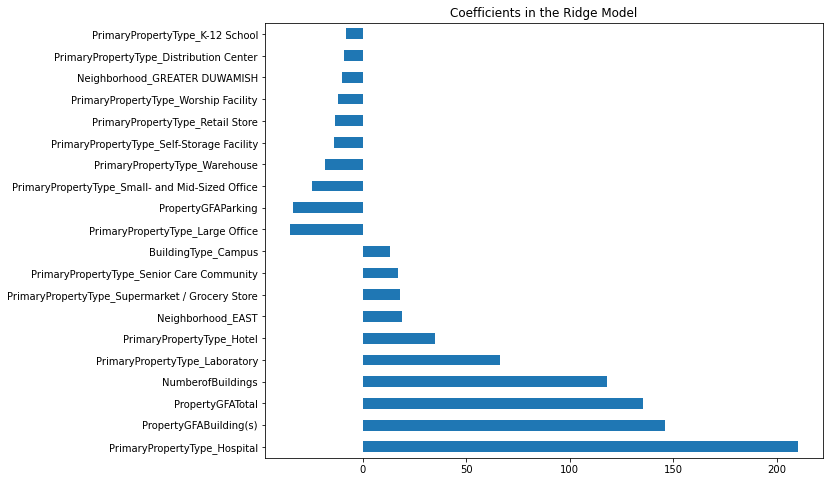

In [17]:
# on affiche les variables les plus importantes du modèle, relativement aux coefficients calculés
coef = pd.Series(ridge_reg.coef_, index = X_train.columns)

imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values().head(10)])

imp_coef

plt.figure(figsize= (10,8))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model");

### Regression Ridge à noyau 

In [18]:
# valeurs du paramètre alpha
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'r2'

# initialiser la validation croisée
grid_pred = model_selection.GridSearchCV(kernel_ridge.KernelRidge(kernel='rbf'),
                                         param_grid,
                                         cv=5,
                                         scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=KernelRidge(kernel='rbf'),
             param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
             scoring='r2')

In [19]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

# Score R2
print('score train :', grid_pred.score(X_train_std, y_train))
print('score test :', grid_pred.score(X_test_std, y_test))

#Score RMSE
print('rmse train :', np.sqrt(mean_squared_error(y_test, grid_pred.predict(X_test_std))))
print('rmse test :', np.sqrt(mean_squared_error(y_train, grid_pred.predict(X_train_std))))

alpha sélectionné par c-v : 50.0
score train : 0.9772860778682033
score test : 0.5210610077442429
rmse train : 204.75573512969825
rmse test : 81.00706531141786


In [20]:
# On ajoute les scores au dataframe results
results = add_results(grid_pred, 'Ridge à Noyau', 'Premières prédictions', results)

### Regression Lasso

La régression Lasso nous permet d'annuler certains coefficients. 
Il s'agit d'une méthode de sélection de variables et de réduction de dimension supervisée : les variables qui ne sont pas nécessaires à la prédiction de l'étiquette sont éliminées.

In [21]:
#on va tester un certain nombre de coefficients pour trouver celui qui est optimal
alphas =(1, 0.1, 0.001, 0.0005,10,20,30,100)

lasso_reg = LassoCV(alphas = alphas, tol=1e-2)
lasso_reg.fit(X_train_std, y_train)

LassoCV(alphas=(1, 0.1, 0.001, 0.0005, 10, 20, 30, 100), tol=0.01)

In [22]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

# Score R2
print('score train :', lasso_reg.score(X_train_std, y_train))
print('score test :', lasso_reg.score(X_test_std, y_test))

#Score RMSE
print('rmse train :', np.sqrt(mean_squared_error(lasso_reg.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(lasso_reg.predict(X_test_std), y_test)))

alpha sélectionné par c-v : 50.0
score train : 0.7774193059556611
score test : 0.4625461291612474
rmse train : 253.5832589208212
rmse test : 216.9035072963488


In [23]:
# On ajoute les scores au dataframe results
results = add_results(lasso_reg, 'LassoCV', 'Premières prédictions', results)

In [24]:
coef = pd.Series(lasso_reg.coef_, index = X_train.columns)
print("Lasso a gardé " + str(sum(coef != 0)) + " variables et a éliminé les " +  str(sum(coef == 0)) + " autres variables")


Lasso a gardé 18 variables et a éliminé les 33 autres variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

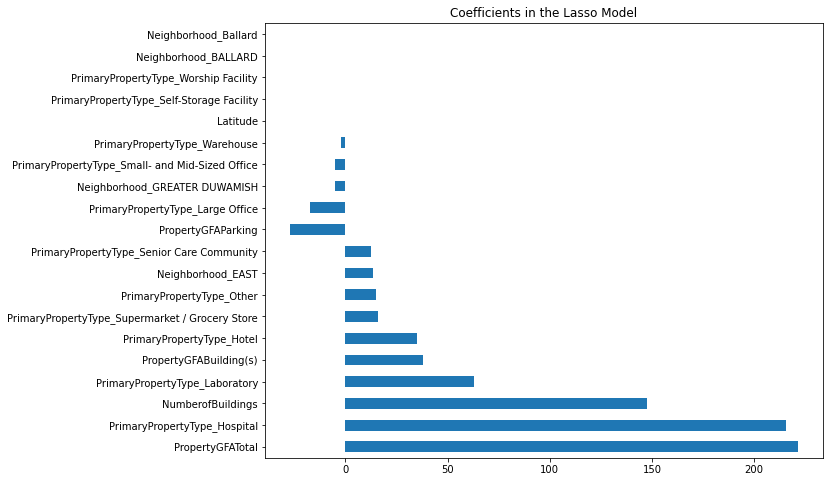

In [25]:
# on affiche les variables les plus importantes du modèle, relativement aux coefficients calculés
imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values().head(10)])


plt.figure(figsize= (10,8))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

La regression Lasso permet de supprimer des variables en mettant leur poids à zéro. C'est le cas si deux variables sont corrélées. L'une sera sélectionnée par le Lasso, l'autre supprimée. C'est aussi son avantage par rapport à une régression ridge qui ne fera pas de sélection de variables.

## Elastic Net

La méthode Elastic Net qui combine les deux termes de régularisation Ridge et Lasso en un pour obtenir une solution moins parcimonieuse que le lasso, mais plus stable et dans laquelle toutes les variables corrélées pertinentes pour la prédiction de l'étiquette sont sélectionnées et reçoivent un poids identique.

In [26]:
model_en = ElasticNetCV(cv = 10, # nombre de folds de validation croisée
                        l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))

# Optimiser ce regresseur sur le jeu d'entraînement
model_en.fit(X_train_std, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=10, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

In [27]:
# Afficher le paramètre alpha optimal
print("alpha sélectionné par c-v :", model_en.alpha_)

#les scores R2 pour les deux echantillons
print('score train :', model_en.score(X_train_std, y_train))
print('score test :', model_en.score(X_test_std, y_test))

# Les racines des erreurs quadratiques moyennes pour les 2 echantillons
print('rmse train',np.sqrt(mean_squared_error(y_train, model_en.predict(X_train_std))))
print('rmse test', np.sqrt(mean_squared_error(y_test, model_en.predict(X_test_std))))


alpha sélectionné par c-v : 0.5
score train : 0.7835896069419963
score test : 0.48604677102671645
rmse train 250.0436844130831
rmse test 212.1083553089565


In [28]:
# On ajoute les scores au dataframe results
results = add_results(lasso_reg, 'Elastic Net', 'Premières prédictions', results)

In [29]:
coeffs = list(model_en.coef_)
coeffs.insert(0, model_en.intercept_)
feats = list(X.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,160.913765
Latitude,1.919396
Longitude,1.412827
YearBuilt,7.058527
NumberofBuildings,118.864145
NumberofFloors,-1.413575
PropertyGFATotal,134.563631
PropertyGFAParking,-32.717922
PropertyGFABuilding(s),146.064465
BuildingType_Campus,13.260993


Text(0.5, 1.0, 'Coefficients in the Elastic Net Model')

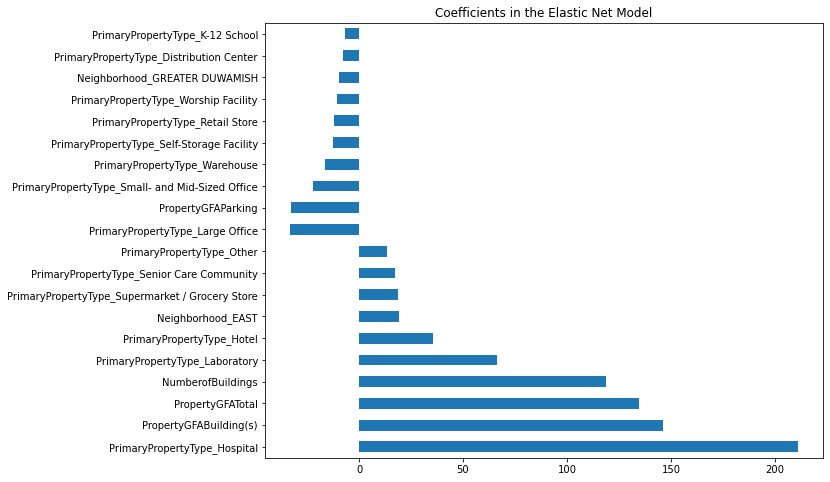

In [30]:
# on affiche les variables les plus importantes du modèle, relativement aux coefficients calculés
coef = pd.Series(model_en.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values().head(10)])


plt.figure(figsize= (10,8))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

In [31]:
coef = pd.Series(model_en.coef_, index = X_train.columns)
print("Elastic Net a gardé " + str(sum(coef != 0)) + " variables et a éliminé les " +  str(sum(coef == 0)) + " autres variables")


Elastic Net a gardé 45 variables et a éliminé les 6 autres variables


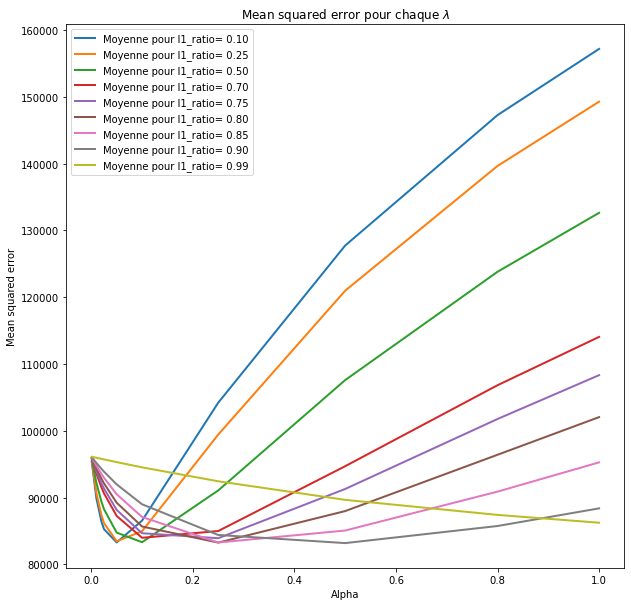

In [32]:
#pour chaque valeur de l1_ratio, on affiche la courbe représentant la moyenne des erreurs MSE obtenues 
#par validation croisée en fonction des valeurs de α
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();


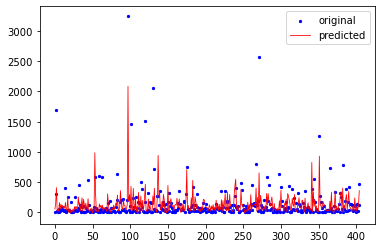

In [33]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
y_pred_en = model_en.predict(X_test_std)
plt.plot(x_ax, y_pred_en, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

## KNN Regressor

In [34]:
#on fait un grid_search pour trouver les meilleurs hyperparamétres
from sklearn import neighbors
# Fixer les valeurs des hyperparamètres à tester
parametres = {'n_neighbors': [i for i in np.arange(2,51,1)]}

# Créer un regresseur kNN avec recherche d'hyperparamètre par validation croisée
grid_knn = model_selection.GridSearchCV(estimator = neighbors.KNeighborsRegressor(),  # un regresseur kNN
                                        param_grid = parametres,                      # hyperparamètres à tester
                                        #cv=10,                                       # nombre de folds de validation croisée
                                        scoring = 'r2',                               # score à optimiser
                                       #n_jobs = -1
                                       )                                    

# Optimiser ce regresseur sur le jeu d'entraînement
grid_knn.fit(X_train_std, y_train)


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...]},
             scoring='r2')

In [35]:
# Afficher le(s) hyperparamètre(s) optimaux
print("le meilleur paramètre 'n_neighbors' selectionné", grid_knn.best_params_)

# Les scores R2
print('score train :', grid_knn.score(X_train_std, y_train))
print('score test :', grid_knn.score(X_test_std, y_test))

# Les scores RMSE
print("RMSE train: {:.2f}".format(np.sqrt(mean_squared_error(y_test, grid_knn.predict(X_test_std)))))
print("RMSE test: {:.2f}".format(np.sqrt(mean_squared_error(y_train, grid_knn.predict(X_train_std)))))


le meilleur paramètre 'n_neighbors' selectionné {'n_neighbors': 8}
score train : 0.42198018014525673
score test : 0.2285090488307383
RMSE train: 259.87
RMSE test: 408.65


In [36]:
# On ajoute les scores au dataframe results
results = add_results(grid_knn, 'KNN', 'Premières prédictions', results)

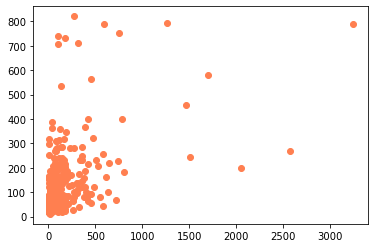

In [37]:
plt.scatter(y_test,grid_knn.predict(X_test_std), color='coral')

## Random Forest Regressor

In [38]:
#on va tester un certain nombre de paramètres pour trouver celui qui est optimal

parameters = {'n_estimators' : [5,10,20,25,30,50,90,100,110,120,130,200], #nombre d'arbres de décision
              'min_samples_leaf' : [1,2,3,4,5,10],           #nombre de feuilles minimales dans un noeud
              'max_features': ['auto', 'sqrt']           #nombre de features observées pour chaque arbre
}

In [39]:
# Créer un regresseur Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
rfr_search = model_selection.GridSearchCV(RandomForestRegressor(n_jobs=-1,random_state=123),
                                          param_grid = parameters,
                                          #refit = 'r2',
                                          scoring='r2',
                                          #verbose=3,
                                          cv=5,
                                          n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
rfr_search.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [5, 10, 20, 25, 30, 50, 90, 100, 110,
                                          120, 130, 200]},
             scoring='r2')

In [40]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le RFR sont :{}".format(rfr_search.best_params_))

# Scores R2
print('score train :', rfr_search.score(X_train_std, y_train))
print('score test :', rfr_search.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(rfr_search.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(rfr_search.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le RFR sont :{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 90}
score train : 0.9248682805354245
score test : 0.4841442086138712
rmse train : 147.3290867642093
rmse test : 212.5005861427968


In [41]:
# On ajoute les scores au dataframe results
results = add_results(rfr_search, 'RFR', 'Premières prédictions', results)

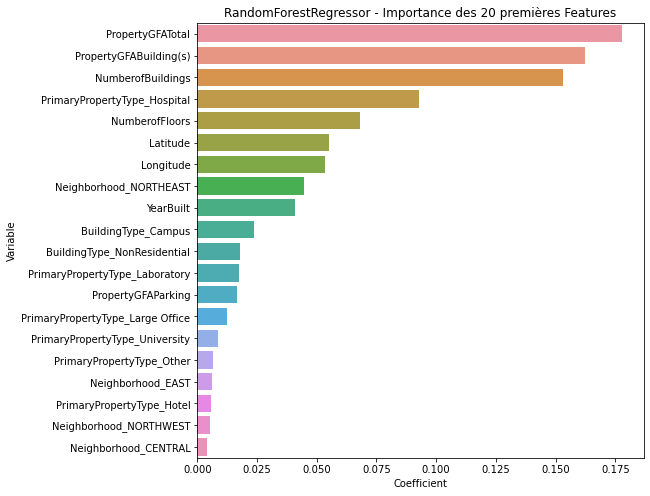

In [42]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(rfr_search.best_estimator_.feature_importances_)
liste_coefs_rfr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rfr['Variable'].head(20),
            x = liste_coefs_rfr['Coefficient'].head(20))
plt.show()

### Support Vector Regression

In [43]:
#on fait un grid_search pour trouver les meilleurs hyperparamétres

# Fixer les valeurs des hyperparamètres à tester
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1,0.2, 1,4,5,6,10],                          #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10,100,500,1000,5000]}                            #parametre de régularisation

# Créer un regresseur SVR avec recherche d'hyperparamètre par validation croisée
svr_grid = model_selection.GridSearchCV(estimator = SVR(), 
                        param_grid = parameters,
                        scoring = 'r2',
                        cv=5,
                        #verbose = 3,
                        n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
svr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000],
                         'epsilon': [0.001, 0.01, 0.1, 0.2, 1, 4, 5, 6, 10],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             scoring='r2')

In [44]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le SVR sont :{}".format(svr_grid.best_params_))

# Afficher le meilleur score
print("le meilleur score est {}".format(svr_grid.best_score_))

# Scores R2
print('score train :', svr_grid.score(X_train_std, y_train))
print('score test :', svr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(svr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(svr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le SVR sont :{'C': 5000, 'epsilon': 10, 'gamma': 0.0001}
le meilleur score est 0.315950128283602
score train : 0.440978451552291
score test : 0.2807948658767623
rmse train : 401.8751081537212
rmse test : 250.91253979877843


In [45]:
# On ajoute les scores au dataframe results
results = add_results(svr_grid, 'SVR', 'Premières prédictions', results)

### Gradient Boosting Regressor 

In [46]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {#'nthread':[3,4], #when use hyperthread, xgboost may become slower
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [47]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 0.6}
score train : 0.8787502875002637
score test : 0.567527737266196
rmse train : 187.16179059567642
rmse test : 194.56965385417877


In [48]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'Premières prédictions', results)

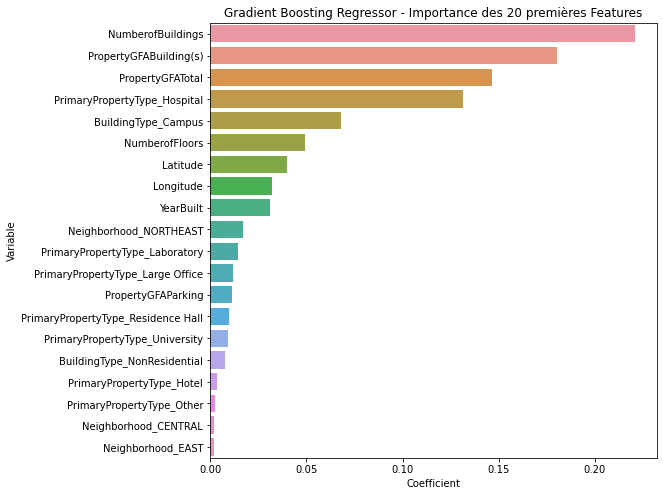

In [49]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

## XGBoost

In [50]:
#on fait un grid_search pour trouver les meilleurs hyperparamétres

# Fixer les valeurs des hyperparamètres à tester
parameters = {'n_estimators' : [5,10,15,20,100,500,1000,2000],
              #"learning_rate": (0.05, 0.10, 0.15),
              "max_depth": [ 3, 4, 5, 6, 8],
              #"min_child_weight": [ 1, 3, 5, 7],
               # "gamma":[ 0.0, 0.1, 0.2],
                #"colsample_bytree":[ 0.3, 0.4],
             }

# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
xgb_grid = model_selection.GridSearchCV(XGBRegressor(n_jobs=-1,random_state=123, subsample=0.9, colsample_bynode=0.2),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        #verbose=3,
                                       n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
xgb_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=0.2, colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_c

In [51]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(xgb_grid.best_params_))

# Scores R2
print('score train :', xgb_grid.score(X_train_std, y_train))
print('score test :', xgb_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(xgb_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(xgb_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'max_depth': 4, 'n_estimators': 100}
score train : 0.9887348876195222
score test : 0.299346381709536
rmse train : 57.04854823582425
rmse test : 247.6553199161114


In [52]:
# On ajoute les scores au dataframe results
results = add_results(xgb_grid, 'XGBoost', 'Premières prédictions', results)

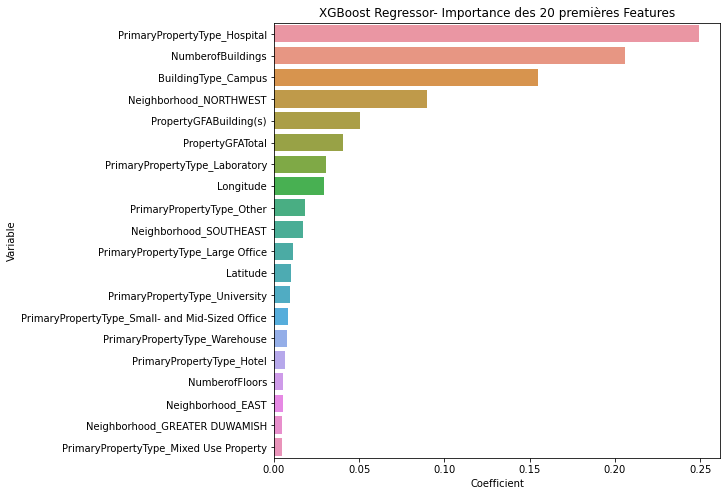

In [53]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(xgb_grid.best_estimator_.feature_importances_)
liste_coefs_xgb = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('XGBoost Regressor- Importance des 20 premières Features')
sns.barplot(y = liste_coefs_xgb['Variable'].head(20),
            x = liste_coefs_xgb['Coefficient'].head(20))
plt.show()

## Resultat du premier essai

In [54]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,296.546062,537.497975,-0.004598,0.000000
1,RidgeCV,Premières prédictions,212.197252,250.011023,0.485616,0.783646
2,Ridge à Noyau,Premières prédictions,204.755735,81.007065,0.521061,0.977286
3,LassoCV,Premières prédictions,216.903507,253.583259,0.462546,0.777419
4,Elastic Net,Premières prédictions,216.903507,253.583259,0.462546,0.777419
5,KNN,Premières prédictions,259.873141,408.646890,0.228509,0.421980
6,RFR,Premières prédictions,212.500586,147.329087,0.484144,0.924868
7,SVR,Premières prédictions,250.912540,401.875108,0.280795,0.440978
8,Gradient Boosting,Premières prédictions,194.569654,187.161791,0.567528,0.878750
9,XGBoost,Premières prédictions,247.655320,57.048548,0.299346,0.988735


#### Dans la suite, on va utiliser que les algorithmes :
- Gradient Boosting
- Random Forest Regressor (RFR)
- RidgeCV

# Deuxième essai de predictions

### Amelioration du feature engineering : utilisation des colonnes de Ratio des property use type et des ratios de type d'energies

On supprime les variables PrimaryPropertyType et on rajoute les variables PropertyUse_ratio et les Ratio d'energies

In [55]:
df_2eme_essai = df.drop(['SiteEnergyUseWN(kBtu)',
                          'ENERGYSTARScore',
                          'PropertyGFABuilding(s)',
                          'NumberofBuildings_log',
                           'NumberofFloors_log',
                           'PropertyGFATotal_log',
                           'PropertyGFAParking_log',
                           'PropertyGFABuilding(s)_log',
                           'SiteEnergyUseWN(kBtu)_log',
                           'TotalGHGEmissions_log'] + columns_PrimaryPropertyType ,
                        axis=1)

### On sépare la variable cible et les features 

In [56]:
X2 = df_2eme_essai.drop(['TotalGHGEmissions'], axis=1)
y2 = df_2eme_essai['TotalGHGEmissions']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [57]:
# On separe les données d'entrainement et de test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X2, y2, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
standardScaler = StandardScaler()
standardScaler.fit(X_train)

X_train_std = pd.DataFrame(data=standardScaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=standardScaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Regression Regularisée : Ridge

In [58]:
#l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard 
# on cherche le coefficient de regularisation alpha adapté
#on va tester un certain nombre de coefficients pour trouver celui qui est optimal
alpha_ridge = (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 20, 30, 50,120, 130,140,150,200, 300, 350, 400)


ridge_reg = RidgeCV(alphas = alpha_ridge, 
                   scoring = 'r2')

ridge_reg.fit(X_train_std, y_train)


RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 3.0e-01, 7.0e-01, 1.0e+00, 1.0e+01,
       2.0e+01, 3.0e+01, 5.0e+01, 1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02,
       2.0e+02, 3.0e+02, 3.5e+02, 4.0e+02]),
        scoring='r2')

In [59]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

alpha sélectionné par c-v : 50.0


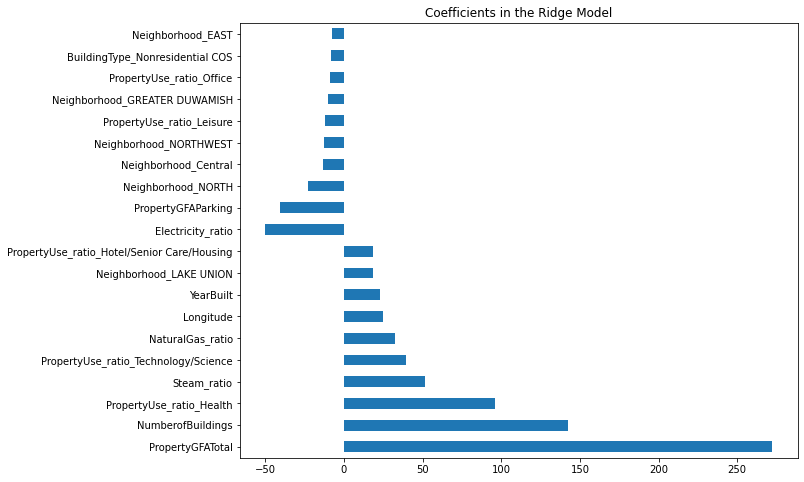

In [60]:
# on affiche les variables les plus importantes du modèle, relativement aux coefficients calculés
coef = pd.Series(ridge_reg.coef_, index = X_train.columns)

imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values().head(10)])

plt.figure(figsize= (10,8))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model");

In [61]:
# On ajoute les scores au dataframe results
results = add_results(ridge_reg, 'RidgeCV', "Essai avec les ratios des Use Types et d'energie", results)


### Random Forest Regressor 

In [62]:
#on va tester un certain nombre de paramètres pour trouver celui qui est optimal

parameters = {'n_estimators' : [5,10,20,25,30,50,90,100,200], #nombre d'arbres de décision
              'min_samples_leaf' : [1,2,3,4,5,10],                        #nombre de feuilles minimales dans un noeud
              'max_features': ['auto', 'sqrt']                            #nombre de features observées pour chaque arbre
}

In [63]:
# Créer un regresseur Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
rfr_search = model_selection.GridSearchCV(RandomForestRegressor(n_jobs=-1,random_state=123),
                                          param_grid = parameters,
                                          #refit = 'r2',
                                          scoring='r2',
                                          #verbose=3,
                                          cv=5,
                                          n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
rfr_search.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [5, 10, 20, 25, 30, 50, 90, 100, 200]},
             scoring='r2')

In [64]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le RFR sont :{}".format(rfr_search.best_params_))

les meilleurs hyperparamètres pour le RFR sont :{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 90}


In [65]:
# On ajoute les scores au dataframe results
results = add_results(rfr_search, 'RFR', "Essai avec les ratios des Use Typeset d'energie", results)


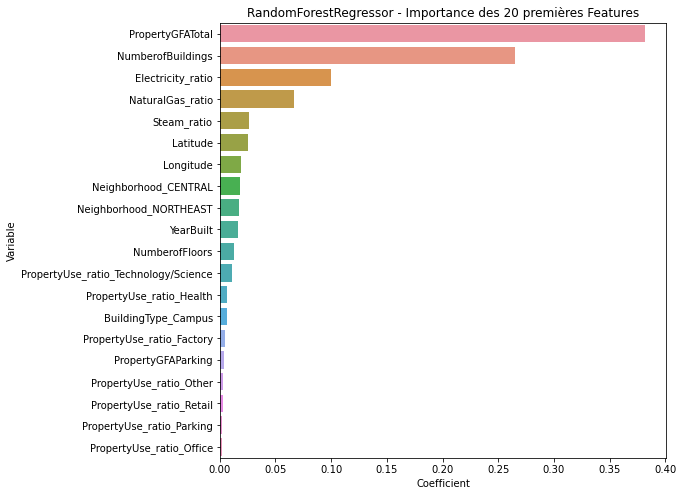

In [66]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(rfr_search.best_estimator_.feature_importances_)
liste_coefs_rfr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rfr['Variable'].head(20),
            x = liste_coefs_rfr['Coefficient'].head(20))
plt.show()

### Gradient Boosting Regressor 

In [67]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {#'nthread':[3,4], #when use hyperthread, xgboost may become slower
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [68]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le GBR sont :{}".format(gbr_grid.best_params_))


les meilleurs hyperparamètres pour le GBR sont :{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 500, 'subsample': 0.8}


In [69]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', "Essai avec les ratios des Use Types et d'energie", results)

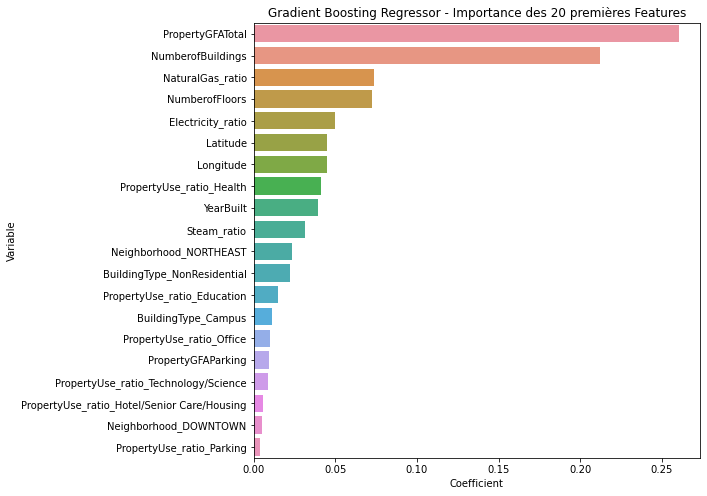

In [70]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

## Resultat du deuxième essai

In [71]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,296.546062,537.497975,-0.004598,0.000000
1,RidgeCV,Premières prédictions,212.197252,250.011023,0.485616,0.783646
2,Ridge à Noyau,Premières prédictions,204.755735,81.007065,0.521061,0.977286
3,LassoCV,Premières prédictions,216.903507,253.583259,0.462546,0.777419
4,Elastic Net,Premières prédictions,216.903507,253.583259,0.462546,0.777419
5,KNN,Premières prédictions,259.873141,408.646890,0.228509,0.421980
6,RFR,Premières prédictions,212.500586,147.329087,0.484144,0.924868
7,SVR,Premières prédictions,250.912540,401.875108,0.280795,0.440978
8,Gradient Boosting,Premières prédictions,194.569654,187.161791,0.567528,0.878750
9,XGBoost,Premières prédictions,247.655320,57.048548,0.299346,0.988735


## Essai 3 : Passage au log pour la variable cible

In [72]:
df_3eme_essai = df.drop(['SiteEnergyUseWN(kBtu)',
                          'ENERGYSTARScore',
                         'TotalGHGEmissions',
                         'PropertyGFAParking',
                         'NumberofBuildings',
                         'NumberofFloors',
                          'NumberofBuildings_log',
                           'NumberofFloors_log', 
                           'PropertyGFATotal_log',
                           'PropertyGFAParking_log',
                           'PropertyGFABuilding(s)_log',
                           'SiteEnergyUseWN(kBtu)_log'] + columns_PrimaryPropertyType ,
                        axis=1)

### On sépare la variable cible et les features 

In [73]:
X3 = df_3eme_essai.drop(['TotalGHGEmissions_log'], axis=1)
y3 = df_3eme_essai['TotalGHGEmissions_log']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [74]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X3, y3, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
standardScaler = StandardScaler()
standardScaler.fit(X_train)

X_train_std = pd.DataFrame(data=standardScaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=standardScaler.transform(X_test),index=X_test.index,columns=X_test.columns)

## Regression Regularisée : Ridge

In [75]:
#l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard 
# on cherche le coefficient de regularisation alpha adapté
#on va tester un certain nombre de coefficients pour trouver celui qui est optimal

ridge_reg = RidgeCV(alphas = (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 20, 30, 50, 100, 200, 300, 350, 400))
ridge_reg.fit(X_train_std, y_train)

RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 3.0e-01, 7.0e-01, 1.0e+00, 1.0e+01,
       2.0e+01, 3.0e+01, 5.0e+01, 1.0e+02, 2.0e+02, 3.0e+02, 3.5e+02,
       4.0e+02]))

In [76]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

alpha sélectionné par c-v : 400.0


In [77]:
# On ajoute les scores au dataframe results
results = add_results(ridge_reg, 'RidgeCV', 'Passage au log de la variable cible', results)


## Random Forest Regressor

In [78]:
#on va tester un certain nombre de paramètres pour trouver celui qui est optimal

parameters = {'n_estimators' : [5,10,20,25,30,50,90,100,110,120,130,200], #nombre d'arbres de décision
              'min_samples_leaf' : [1,2,3,4,5,10],                        #nombre de feuilles minimales dans un noeud
              'max_features': ['auto', 'sqrt']                            #nombre de features observées pour chaque arbre
}
# Créer un regresseur Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
rfr_search = model_selection.GridSearchCV(RandomForestRegressor(n_jobs=-1,random_state=123),
                                          param_grid = parameters,
                                          #refit = 'r2',
                                          scoring='r2',
                                          cv=5,
                                          n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
rfr_search.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [5, 10, 20, 25, 30, 50, 90, 100, 110,
                                          120, 130, 200]},
             scoring='r2')

In [79]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le RFR sont :{}".format(rfr_search.best_params_))

les meilleurs hyperparamètres pour le RFR sont :{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 120}


In [80]:
# On ajoute les scores au dataframe results
results = add_results(rfr_search, 'RFR', 'Passage au log de la variable cible', results)


### Gradient Boosting Regressor 

In [81]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {#'nthread':[3,4], #when use hyperthread, xgboost may become slower
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [82]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le GBR sont :{}".format(gbr_grid.best_params_))


les meilleurs hyperparamètres pour le GBR sont :{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 500, 'subsample': 0.8}


In [83]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'Passage au log de la variable cible', results)

### Résultat du 3ème essai

In [84]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,296.546062,537.497975,-0.004598,0.000000
1,RidgeCV,Premières prédictions,212.197252,250.011023,0.485616,0.783646
2,Ridge à Noyau,Premières prédictions,204.755735,81.007065,0.521061,0.977286
3,LassoCV,Premières prédictions,216.903507,253.583259,0.462546,0.777419
4,Elastic Net,Premières prédictions,216.903507,253.583259,0.462546,0.777419
5,KNN,Premières prédictions,259.873141,408.646890,0.228509,0.421980
6,RFR,Premières prédictions,212.500586,147.329087,0.484144,0.924868
7,SVR,Premières prédictions,250.912540,401.875108,0.280795,0.440978
8,Gradient Boosting,Premières prédictions,194.569654,187.161791,0.567528,0.878750
9,XGBoost,Premières prédictions,247.655320,57.048548,0.299346,0.988735


## Essai 4 : Passage au log pour les features asymétriques

In [85]:
#On prends le variables 'PropertyGFATotal_log' et 'PropertyGFABuilding(s)_log'
df_4eme_essai = df.drop(['SiteEnergyUseWN(kBtu)',
                          'ENERGYSTARScore',
                         'TotalGHGEmissions',
                         'PropertyGFAParking',
                         'NumberofBuildings',
                         'NumberofFloors',
                          'NumberofBuildings_log',
                           'NumberofFloors_log', 
                           'PropertyGFATotal',
                           'PropertyGFAParking_log',
                           'PropertyGFABuilding(s)',
                           'SiteEnergyUseWN(kBtu)_log'] + columns_PrimaryPropertyType ,
                        axis=1)

<AxesSubplot:>

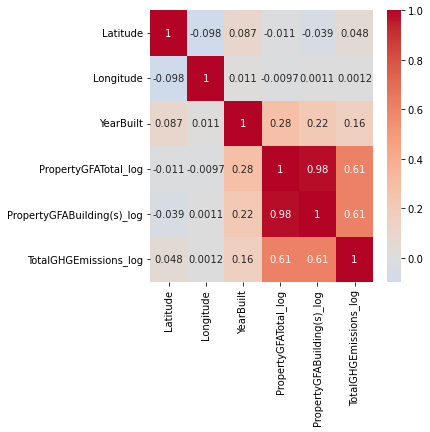

In [86]:
#on affiche une heatmap de correlation entre chaque variables 
plt.figure(figsize=(5, 5))
sns.heatmap(df_4eme_essai[['Latitude', 
                          'Longitude', 
                          'YearBuilt',
                          'PropertyGFATotal_log',
                          'PropertyGFABuilding(s)_log',
                          'TotalGHGEmissions_log']].corr(), annot=True, cmap='coolwarm', center = 0)

### On sépare la variable cible et les features 

In [87]:
X4 = df_4eme_essai.drop(['TotalGHGEmissions_log'], axis=1)
y4 = df_4eme_essai['TotalGHGEmissions_log']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [88]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X4, y4, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
standardScaler = StandardScaler()
standardScaler.fit(X_train)

X_train_std = pd.DataFrame(data=standardScaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=standardScaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Regression Regularisée : Ridge

In [89]:
#l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard 
# on cherche le coefficient de regularisation alpha adapté
#on va tester un certain nombre de coefficients pour trouver celui qui est optimal

ridge_reg = RidgeCV(alphas = (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 20, 30, 50, 100, 200, 300, 350, 400))
ridge_reg.fit(X_train_std, y_train)

RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 3.0e-01, 7.0e-01, 1.0e+00, 1.0e+01,
       2.0e+01, 3.0e+01, 5.0e+01, 1.0e+02, 2.0e+02, 3.0e+02, 3.5e+02,
       4.0e+02]))

In [90]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

alpha sélectionné par c-v : 30.0


In [91]:
# On ajoute les scores au dataframe results
results = add_results(ridge_reg, 'RidgeCV', 'Passage au log des features asymétriques', results)


### Random Forest Regressor

In [92]:
#on va tester un certain nombre de paramètres pour trouver celui qui est optimal

parameters = {'n_estimators' : [5,10,20,25,30,50,90,100,110,120,130,200], #nombre d'arbres de décision
              'min_samples_leaf' : [1,2,3,4,5,10],                        #nombre de feuilles minimales dans un noeud
              'max_features': ['auto', 'sqrt']                            #nombre de features observées pour chaque arbre
}
# Créer un regresseur Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
rfr_search = model_selection.GridSearchCV(RandomForestRegressor(n_jobs=-1,random_state=123),
                                          param_grid = parameters,
                                          scoring='r2',
                                          cv=5,
                                          n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
rfr_search.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [5, 10, 20, 25, 30, 50, 90, 100, 110,
                                          120, 130, 200]},
             scoring='r2')

In [93]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le RFR sont :{}".format(rfr_search.best_params_))

les meilleurs hyperparamètres pour le RFR sont :{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 130}


In [94]:
# On ajoute les scores au dataframe results
results = add_results(rfr_search, 'RFR', 'Passage au log des features asymétriques', results)


### Gradient Boosting Regressor

In [95]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [96]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le GBR sont :{}".format(gbr_grid.best_params_))


les meilleurs hyperparamètres pour le GBR sont :{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 500, 'subsample': 0.7}


In [97]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'Passage au log des features asymétriques', results)

### Résultat du 4ème essai

In [98]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,296.546062,537.497975,-0.004598,0.000000
1,RidgeCV,Premières prédictions,212.197252,250.011023,0.485616,0.783646
2,Ridge à Noyau,Premières prédictions,204.755735,81.007065,0.521061,0.977286
3,LassoCV,Premières prédictions,216.903507,253.583259,0.462546,0.777419
4,Elastic Net,Premières prédictions,216.903507,253.583259,0.462546,0.777419
5,KNN,Premières prédictions,259.873141,408.646890,0.228509,0.421980
6,RFR,Premières prédictions,212.500586,147.329087,0.484144,0.924868
7,SVR,Premières prédictions,250.912540,401.875108,0.280795,0.440978
8,Gradient Boosting,Premières prédictions,194.569654,187.161791,0.567528,0.878750
9,XGBoost,Premières prédictions,247.655320,57.048548,0.299346,0.988735


## Essai 5 : optimisation du modèle
On garde que le gradient Boosting Regressor qui a les meilleurs scores et on optimise les hyperparamètres pour avoir un meilleur score et on change la méthode de scaling

In [99]:
df_5eme_essai = df.drop(['SiteEnergyUseWN(kBtu)',
                          'ENERGYSTARScore',
                         'TotalGHGEmissions',
                         'PropertyGFAParking',
                         'NumberofBuildings',
                         'NumberofFloors',
                          'NumberofBuildings_log',
                           'NumberofFloors_log', 
                           'PropertyGFATotal',
                           'PropertyGFAParking_log',
                           'PropertyGFABuilding(s)',
                           'SiteEnergyUseWN(kBtu)_log'] 
                        + columns_PrimaryPropertyType
                        #+ columns_BuildingType
                        #+ columns_Neighborhood
                        ,axis=1)

### On sépare la variable cible et les features 

In [100]:
X5 = df_5eme_essai.drop(['TotalGHGEmissions_log'], axis=1)
y5 = df_5eme_essai['TotalGHGEmissions_log']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [101]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X5, y5, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X_train)

X_train_std = pd.DataFrame(data=robustscaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=robustscaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Gradient Boosting Regressor

In [102]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":[None, "log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [3,4,5],
              #'subsample': [0.6,0.7,0.75,0.8],
              'n_estimators': [400,500,600],     #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [3, 4, 5],
                         'n_estimators': [400, 500, 600]},
             scoring='r2')

In [103]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
score train : 0.9361692363185787
score test : 0.7608546201680679
rmse train : 0.3596455627697276
rmse test : 0.6726080378499036


In [104]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
score train : 0.9361692363185787
score test : 0.7608546201680679
rmse train : 0.3596455627697276
rmse test : 0.6726080378499036


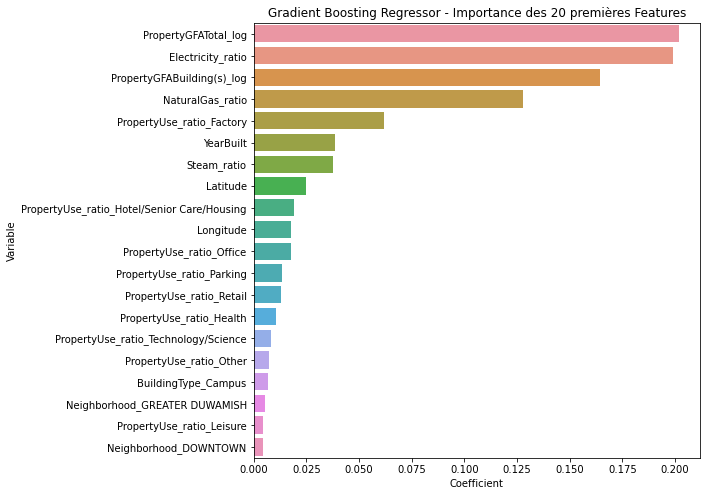

In [105]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

In [106]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'optimisation des hyperparamètres', results)

### Résultats du 5eme essai

In [107]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,296.546062,537.497975,-0.004598,0.000000
1,RidgeCV,Premières prédictions,212.197252,250.011023,0.485616,0.783646
2,Ridge à Noyau,Premières prédictions,204.755735,81.007065,0.521061,0.977286
3,LassoCV,Premières prédictions,216.903507,253.583259,0.462546,0.777419
4,Elastic Net,Premières prédictions,216.903507,253.583259,0.462546,0.777419
5,KNN,Premières prédictions,259.873141,408.646890,0.228509,0.421980
6,RFR,Premières prédictions,212.500586,147.329087,0.484144,0.924868
7,SVR,Premières prédictions,250.912540,401.875108,0.280795,0.440978
8,Gradient Boosting,Premières prédictions,194.569654,187.161791,0.567528,0.878750
9,XGBoost,Premières prédictions,247.655320,57.048548,0.299346,0.988735


## Verification de la performance du modèle avec un KFold cross-validation

In [108]:
df_6eme_essai = df.drop(['SiteEnergyUseWN(kBtu)',
                          'ENERGYSTARScore',
                         'TotalGHGEmissions',
                         'PropertyGFAParking',
                         'NumberofBuildings',
                         'NumberofFloors',
                          'NumberofBuildings_log',
                           'NumberofFloors_log', 
                           'PropertyGFATotal',
                           'PropertyGFAParking_log',
                           'PropertyGFABuilding(s)',
                           'SiteEnergyUseWN(kBtu)_log'] 
                        + columns_PrimaryPropertyType
                        ,axis=1)

In [109]:
X6= df_6eme_essai.drop(['TotalGHGEmissions_log'], axis=1)
y6= df_6eme_essai['TotalGHGEmissions_log']

In [110]:
#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X6)

X6_std = pd.DataFrame(data=robustscaler.transform(X6),index=X6.index,columns=X6.columns)


In [111]:
from sklearn.model_selection import KFold, cross_val_score,cross_val_predict

parameters = {'learning_rate': 0.005, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
model = GradientBoostingRegressor(random_state=123, **parameters)

scores = cross_val_score(model, X6_std, y6, 
                         scoring='r2',
                         cv=KFold(10), n_jobs=-1)

In [112]:
#That is, the average r2 error between the model prediction and the actual observed data
np.mean(abs(scores))

0.5356196922112628

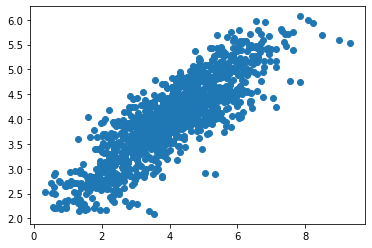

In [113]:
# Make cross validated predictions
predictions = cross_val_predict(model, X6_std, y6, cv=10)
plt.scatter(y6, predictions);

In [114]:
accuracy = r2_score(y6, predictions)
print('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: 0.634373733854543


## Analyse de l’influence de l’EnergyStarScore sur le modèle choisi

### Le modèle choisi est le modèle avec passage au log et l'algorithme **Gradient Boosting Regressor**

On va entraîner le modèle final choisi avec le nouveau dataset,
une fois avec la feature EnergyStarScore,
une fois sans cette feature 
et comparer les scores et la feature importance, afin de démontrer l’apport réel de cette feature


### On ne garde que le dataframe avec des lignes où l'Energie Star Score est présent

In [115]:
#On supprime les lignes où il y a une valeur manquante (Energy Star Score)
df_dropna_ess = df.dropna(axis =0)

In [116]:
missingValues(df_dropna_ess)

,Variable Name,Count,Percentage


In [117]:
missingValues(df)

,Variable Name,Count,Percentage
0,ENERGYSTARScore,473,35.09


### Entrainement du modèle finale sans l'Energie Star Score

In [118]:
df_sans_ess = df_dropna_ess.drop(['SiteEnergyUseWN(kBtu)',
                          'ENERGYSTARScore',
                         'TotalGHGEmissions',
                         'PropertyGFAParking',
                         'NumberofBuildings',
                         'NumberofFloors',
                          'NumberofBuildings_log',
                           'NumberofFloors_log', 
                           'PropertyGFATotal',
                           'PropertyGFAParking_log',
                           'PropertyGFABuilding(s)',
                           'SiteEnergyUseWN(kBtu)_log'] + columns_PrimaryPropertyType ,
                        axis=1)

In [119]:
#Nous allons séparer les données en un ensemble de données X 
#et une variable cible y que nous voulons prédire
X_sans_ess = df_sans_ess.drop(['TotalGHGEmissions_log'], axis=1)
y_sans_ess = df_sans_ess['TotalGHGEmissions_log']


In [120]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_sans_ess, y_sans_ess, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X_train)

X_train_std = pd.DataFrame(data=robustscaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=robustscaler.transform(X_test),index=X_test.index,columns=X_test.columns)

## Gradient Boosting Regressor sans L'Energy Star Score

In [121]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {#'nthread':[3,4],                  #when use hyperthread, xgboost may become slower
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [122]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 500, 'subsample': 0.6}
score train : 0.9377287421108063
score test : 0.8065020916420252
rmse train : 0.3502322274065246
rmse test : 0.5503058220941848


In [123]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting sans ESS', "Influence de L'Energie Star Score", results)

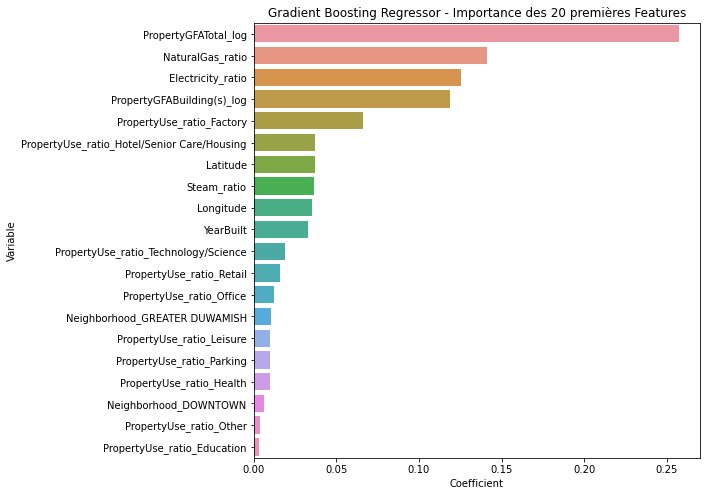

In [124]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

### Entrainement du modèle finale avec l'Energie Star Score

In [125]:
df_ess = df_dropna_ess.drop(['SiteEnergyUseWN(kBtu)',
                         'TotalGHGEmissions',
                         'PropertyGFAParking',
                         'NumberofBuildings',
                         'NumberofFloors',
                          'NumberofBuildings_log',
                           'NumberofFloors_log', 
                           'PropertyGFATotal',
                           'PropertyGFAParking_log',
                           'PropertyGFABuilding(s)',
                           'SiteEnergyUseWN(kBtu)_log'] + columns_PrimaryPropertyType ,
                        axis=1)


In [126]:
#Nous allons séparer les données en un ensemble de données X 
#et une variable cible y que nous voulons prédire.
X_ess = df_ess.drop(['TotalGHGEmissions_log'], axis=1)
y_ess = df_ess['TotalGHGEmissions_log']

In [127]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_ess, y_ess, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X_train)

X_train_std = pd.DataFrame(data=robustscaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=robustscaler.transform(X_test),index=X_test.index,columns=X_test.columns)

## Gradient Boosting Regressor avec L'Energy Star Score

In [128]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [129]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 500, 'subsample': 0.6}
score train : 0.9784497411061327
score test : 0.8836008036502011
rmse train : 0.20603382859130584
rmse test : 0.4268162650272056


In [130]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting avec ESS', "Influence de L'Energie Star Score", results)

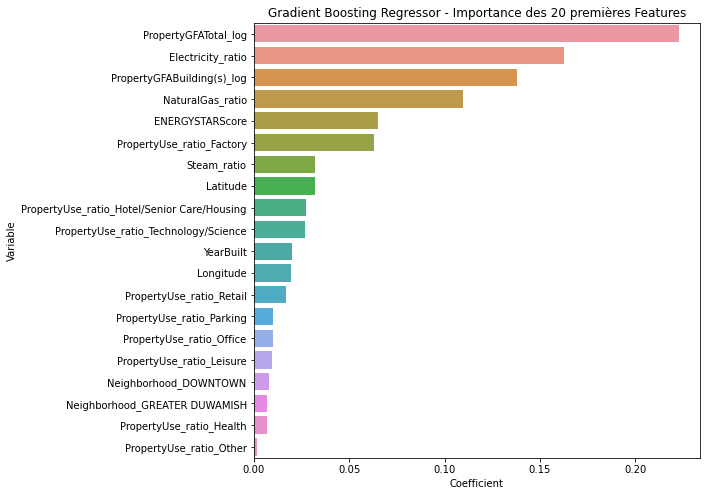

In [131]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

### Resultats finaux 

In [135]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,296.546062,537.497975,-0.004598,0.000000
1,RidgeCV,Premières prédictions,212.197252,250.011023,0.485616,0.783646
2,Ridge à Noyau,Premières prédictions,204.755735,81.007065,0.521061,0.977286
3,LassoCV,Premières prédictions,216.903507,253.583259,0.462546,0.777419
4,Elastic Net,Premières prédictions,216.903507,253.583259,0.462546,0.777419
5,KNN,Premières prédictions,259.873141,408.646890,0.228509,0.421980
6,RFR,Premières prédictions,212.500586,147.329087,0.484144,0.924868
7,SVR,Premières prédictions,250.912540,401.875108,0.280795,0.440978
8,Gradient Boosting,Premières prédictions,194.569654,187.161791,0.567528,0.878750
9,XGBoost,Premières prédictions,247.655320,57.048548,0.299346,0.988735


### Conclusion

L'energie Star Score a bien une influence sur les scores de la prediction de la variable TotalGHGEmissions, quand on le rajoute dans le modèle les scores s'améliorent.

Il apparait comme la 5ème variable plus importante dans le modèle.